Задание выполнил Фролов Алексей 1055591@gmail.com.


Сначала импортируем данные с помощью api moex в датафрейм df.

In [ ]:
# requests позволяет отправляться запросы к ресурсам
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from datetime import date as d

df = pd.DataFrame({"Date": [], "Open": [], "Close": []})

# url получения последних 100 записей по бумаге
url = ("https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/TCSG/.json?limit=100&iss.meta=off&iss.json=extended&lang=ru&sort_column=TRADEDATE&&from={f}&till={t}&start={s}&limit=100&sort_order=desc")

"""
Параметры f -- с какой даты, t -- по какую дату, s -- смещение от н
С помощью такого запроса получаем последние 100 записей в формате J
переменная start позволяет сдвигать курсор на чтение более ранних з
так как API отдает не более 100 записей
"""

for i in range(8):
  h = json.loads(requests.get(url.format(f="2020-02-26", t="2023-02-26", s = str(100*i))).text)[1]



  for dval in h[("history")]:
    if dval["BOARDID"] == "TQBR" and d.fromisoformat(dval["TRADEDATE"]) >= d.fromisoformat("2020-02-26"):
      df = df.append(pd.DataFrame(    {"Date": [dval["TRADEDATE"]], "Open": [dval["OPEN"]], "Close": [dval["LEGALCLOSEPRICE"]]}   ), ignore_index = True)



df.to_csv("file4.csv")

df = df[::-1]


Теперь посмотрим на результат: выведем график с помощью matplotlib.

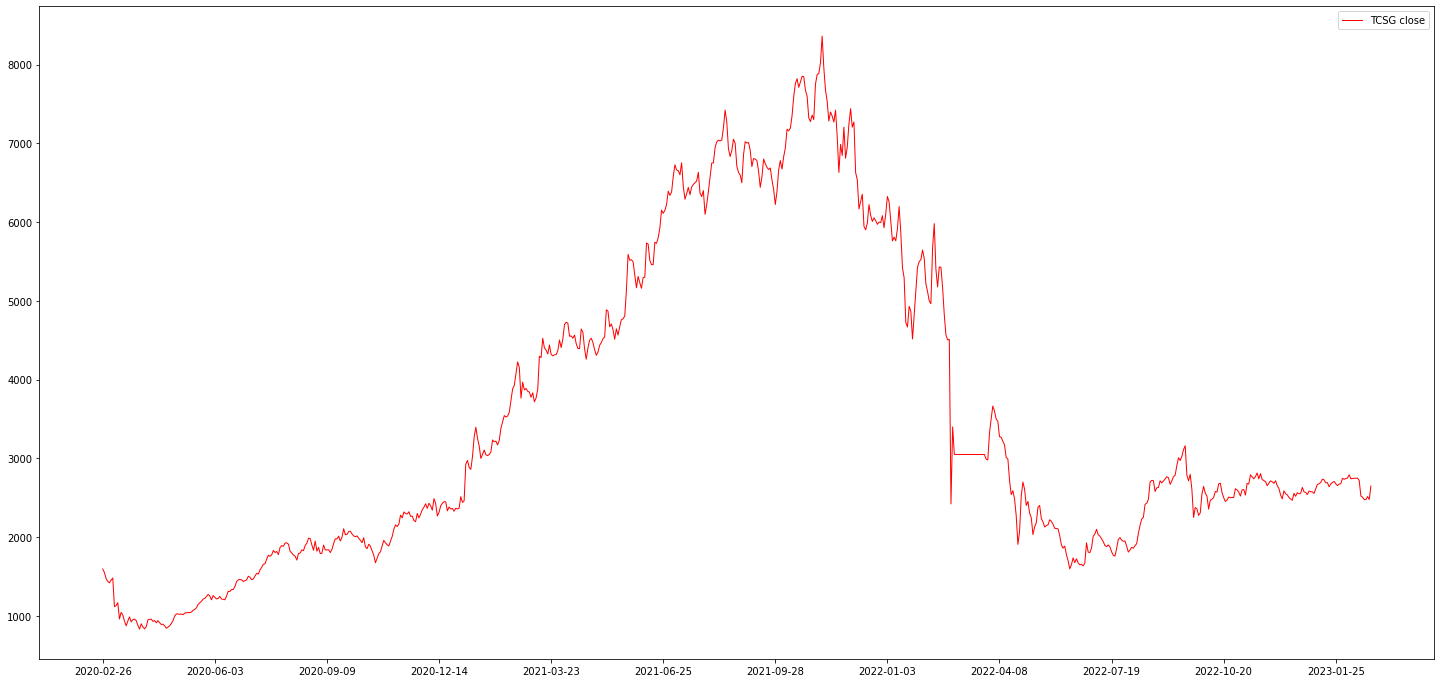

In [ ]:
fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.plot(df["Date"] , df["Close"] , linewidth= 1, color = "red", label = "TCSG close")
plt.legend()




Теперь напишем функцию SMA, в которую будем передавать параметр n - период, за который считаем среднее, по дефолту поставим n = 20. Функция будет добавлять в df столбец со значением средней скользящей. Заодно сразу выведем через matplotlib среднюю на общем графике зеленым цветом.

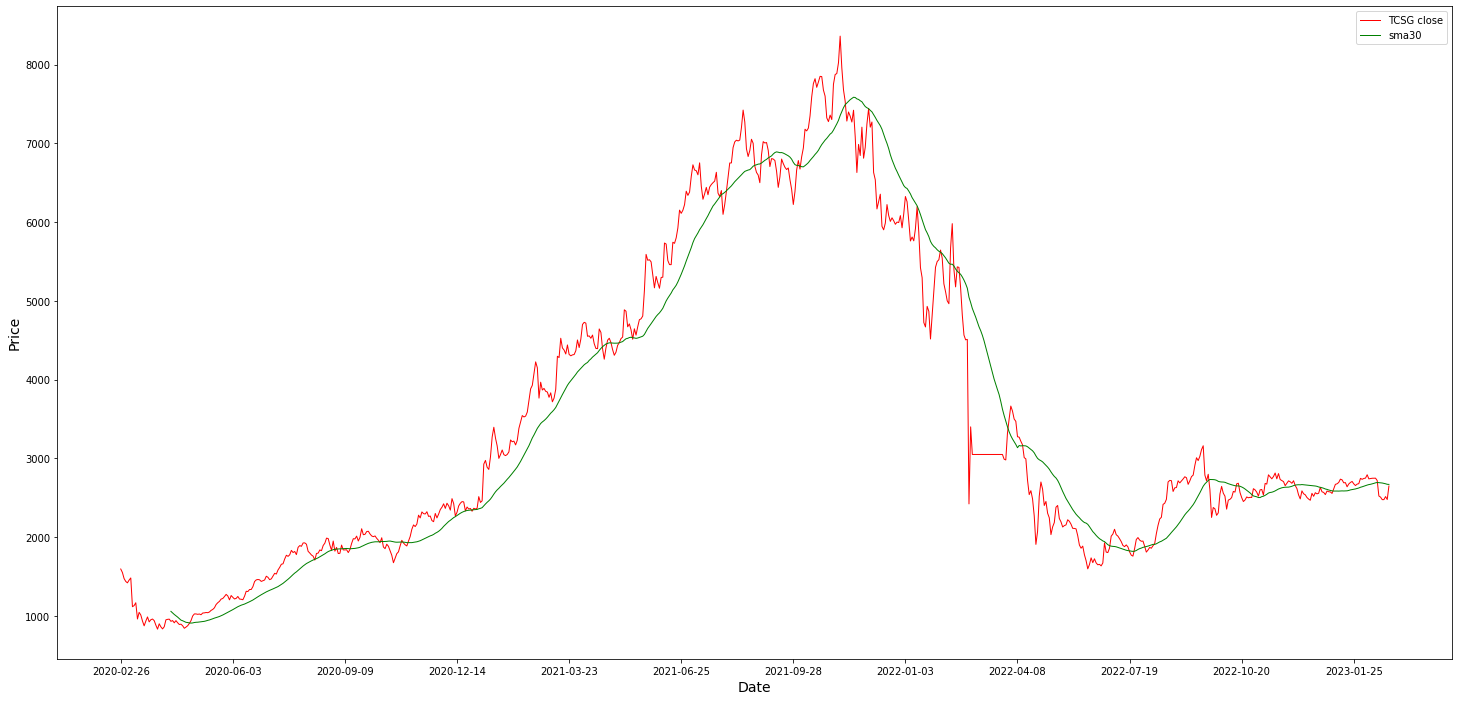

In [ ]:
def sma(n=20):
  sma_list = []
  for i in range(n):
    sma_list.append(None)
  closes = list(el for el in list(df["Close"]))
  closes
  for i in range(n, df.shape[0]):
    sma_list.append(sum(closes[i-n+1:i+1])/n)
  df["sma"+str(n)] = sma_list

sma(30)

fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)


plt.plot(df["Date"] , df["Close"] , linewidth= 1, color = "Red", label = "TCSG close")
plt.plot(df["Date"] , df["sma30"] , linewidth= 1, color = "Green", label = "sma30")
plt.legend()

Теперь то же самое для WMA:

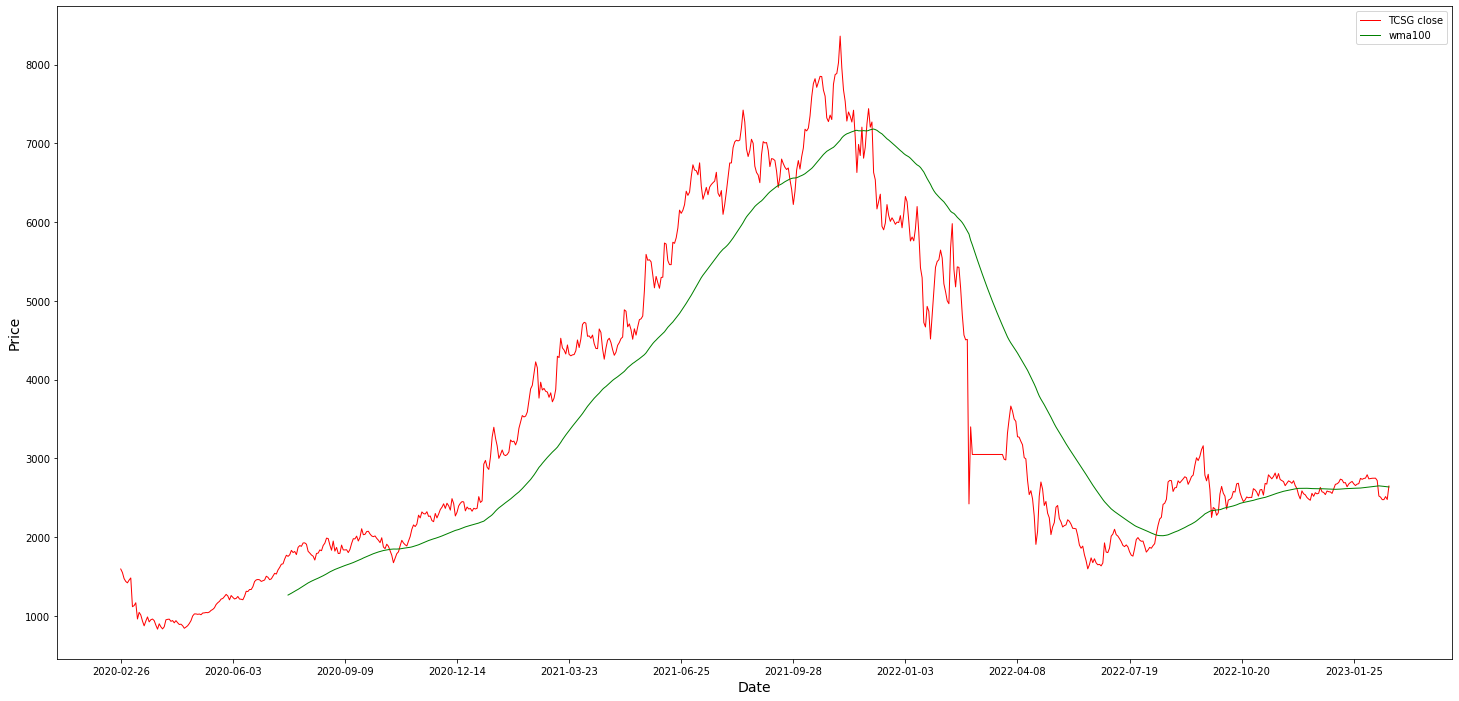

In [ ]:
def wma(n=20):
  wma_list = []
  for i in range(n):
    wma_list.append(None)
  closes = list(el for el in list(df["Close"]))

  for i in range(n, df.shape[0]):
    summ = sum(list((n-j)*closes[i-1-j] for j in range(n)))/sum(list(k for k in range(1, n+1)))

    wma_list.append(summ)

  df["wma"+str(n)] = wma_list

wma(100)

fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)


plt.plot(df["Date"] , df["Close"] , linewidth= 1, color = "Red", label = "TCSG close")
plt.plot(df["Date"] , df["wma100"] , linewidth= 1, color = "Green", label = "wma100")
plt.legend()

И, наконец для экспоненциальной средней:

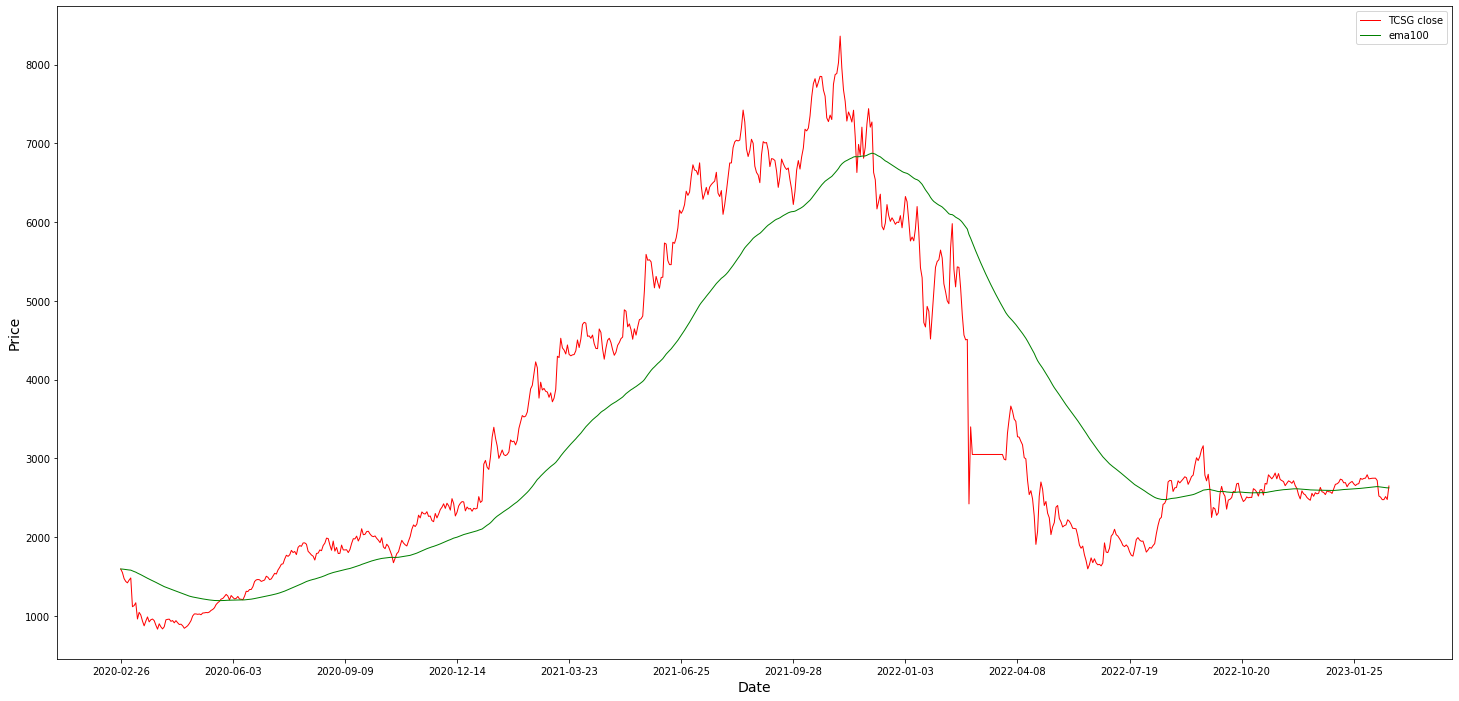

In [ ]:
def ema(n):
  closes = list(el for el in list(df["Close"]))
  k = 2/(n+1)

  ema_list = [closes[0]]

  for i in range(1, df.shape[0]):
    ema_list.append(k*(closes[i])+(1-k)*ema_list[-1])

  df["ema"+str(n)] = ema_list

ema(100)

fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)


plt.plot(df["Date"] , df["Close"] , linewidth= 1, color = "Red", label = "TCSG close")
plt.plot(df["Date"] , df["ema100"] , linewidth= 1, color = "Green", label = "ema100")
plt.legend()


Relative Strength Index. Посчитать его задача несложная, по дефолту в функции поставим период 14 дней - именно на RSI14 ориентируются практически все. Выведем его красиво, как в TradingView - ровно под графиком, и с разметками 30 и 70, что трейдеры воспринимают как перепроданность и перекупленность. (Положим, на неопределенном участке - первые недели, RSI = 50)

In [ ]:
def rsi(n=14):
  rs = []
  closes = list(el for el in list(df["Close"]))
  bars = [0] + list(closes[i] - closes[i-1] for i in range(1, len(closes)))


  for i in range(n):
    rs.append(1)

  for i in range(n, len(closes)):
      rs.append(sum(list(   el for el in bars[i-n: i] if el > 0   ))/ max(-sum(list(   el for el in bars[i-n: i] if el < 0   )), 1))

  rsi = list(100-100/(1+el) for el in rs)
  df["rsi"] = rsi

rsi()

fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.ylabel('Price', fontsize=14)
plt.plot(df["Date"] , df["Close"] , linewidth= 1, color = "Red", label = "TGSG close")
plt.legend()


fig1, ax1 = plt.subplots(figsize=(25,3))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(67))

plt.ylabel('RSI', fontsize=21)
plt.xlabel('Date', fontsize=14)

plt.plot(df["Date"] , df["rsi"] , linewidth= 1, color = "Green")
plt.axhline(y = 70)
plt.axhline(y = 30)



NameError: ignored

На этом в целом все, но можно поиграться и вывести все сразу, возомнив себя опытным трейдером:

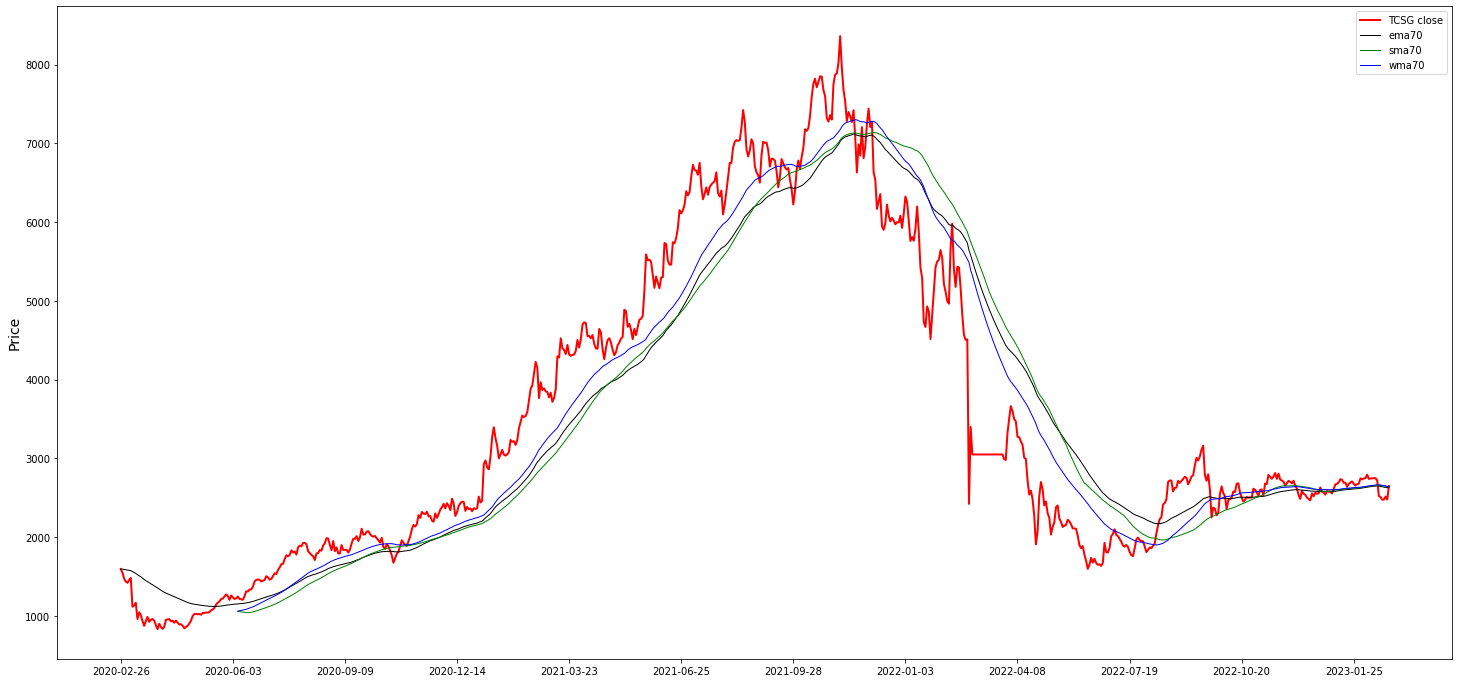

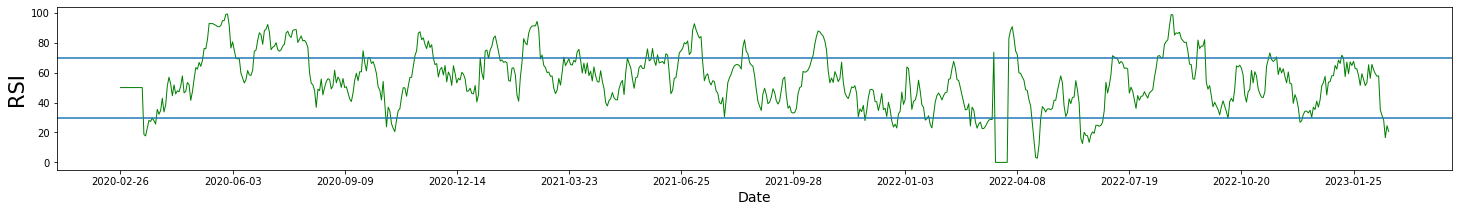

In [ ]:
sma(70)
ema(70)
wma(70)
rsi()




fig, ax = plt.subplots(figsize=(25,12))
ax.xaxis.set_major_locator(ticker.MultipleLocator(67))
plt.ylabel('Price', fontsize=14)
plt.plot(df["Date"] , df["Close"] , linewidth= 2, color = "Red", label = "TCSG close")
plt.plot(df["Date"] , df["ema70"] , linewidth= 1, color = "Black", label = "ema70")
plt.plot(df["Date"] , df["sma70"] , linewidth= 1, color = "Green", label = "sma70")
plt.plot(df["Date"] , df["wma70"] , linewidth= 1, color = "Blue", label = "wma70")
plt.legend()

fig1, ax1 = plt.subplots(figsize=(25,3))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(67))

plt.ylabel('RSI', fontsize=21)
plt.xlabel('Date', fontsize=14)

plt.plot(df["Date"] , df["rsi"] , linewidth= 1, color = "Green")
plt.axhline(y = 70)
plt.axhline(y = 30)